<a href="https://www.kaggle.com/code/swabbie8/ai-cabbage-cnn-2?scriptVersionId=101733429" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
from glob import glob



print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.6.4


In [2]:
training_dir = '../input/cabbagetypescnn/cabbage'

CLASSES = [ 'bokchoy',
            'green',
            'napa',
            'red',
            'savoy']


IMG_SIZE = 150
IMAGE_SIZE = [150, 150]
DIM = (IMG_SIZE, IMG_SIZE)

In [3]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=training_dir, target_size=DIM, batch_size=100, shuffle=False)

Found 100 images belonging to 5 classes.


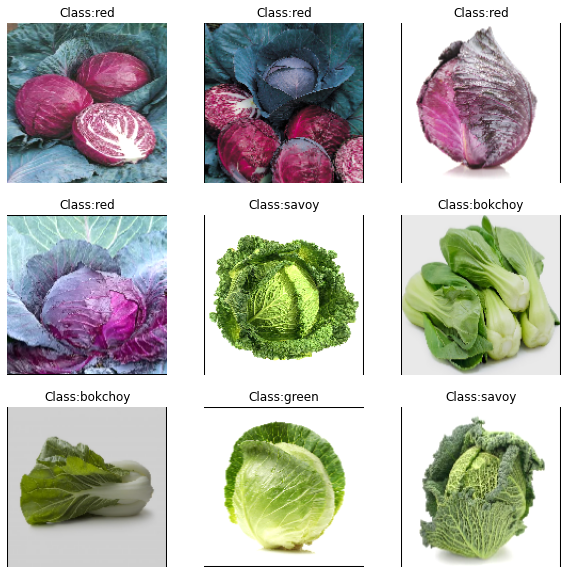

In [4]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3,4], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 99)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [5]:
train_data, train_labels = train_data_gen.next()
print(train_data.shape, train_labels.shape)

(100, 150, 150, 3) (100, 5)


In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [7]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [8]:
# getting the number of classes i.e. type of fruits
folders = glob(training_dir + '/*')
num_classes = len(folders)
print ('Total Classes = ' + str(num_classes))

Total Classes = 5


In [9]:
# importing the libraries
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16
#from keras.preprocessing import image


# loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

# this will exclude the initial layers from training phase as there are already been trained.
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
#x = Dense(128, activation = 'relu')(x)   # we can add a new fully connected layer but it will increase the execution time.
x = Dense(num_classes, activation = 'softmax')(x)  # adding the output layer with softmax function as this is a multi label classification problem.


model = Model(inputs = vgg.input, outputs = x)

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=5)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

2022-07-25 17:26:08.303733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 17:26:08.408313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 17:26:08.409136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 17:26:08.411400: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [10]:
EPOCHS = 100

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100


2022-07-25 17:26:12.020152: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-25 17:26:13.967902: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2/2 [==============================] - 10s 1s/step - loss: 1.7076 - acc: 0.1719 - auc: 0.5359 - f1_score: 0.1367 - val_loss: 1.7966 - val_acc: 0.2500 - val_auc: 0.5566 - val_f1_score: 0.2000
Epoch 2/100
2/2 [==============================] - 0s 80ms/step - loss: 1.2833 - acc: 0.5156 - auc: 0.7783 - f1_score: 0.4760 - val_loss: 1.4327 - val_acc: 0.5625 - val_auc: 0.7090 - val_f1_score: 0.4222
Epoch 3/100
2/2 [==============================] - 0s 115ms/step - loss: 0.9252 - acc: 0.7500 - auc: 0.9212 - f1_score: 0.6914 - val_loss: 1.0529 - val_acc: 0.5625 - val_auc: 0.8794 - val_f1_score: 0.3733
Epoch 4/100
2/2 [==============================] - 0s 79ms/step - loss: 0.6427 - acc: 0.9219 - auc: 0.9929 - f1_score: 0.9219 - val_loss: 0.9257 - val_acc: 0.7500 - val_auc: 0.9214 - val_f1_score: 0.6159
Epoch 5/100
2/2 [==============================] - 0s 77ms/step - loss: 0.4905 - acc: 0.9688 - auc: 0.9972 - f1_score: 0.9695 - val_loss: 0.8897 - val_acc: 0.6875 - val_auc: 0.9180 - val_f1_score:

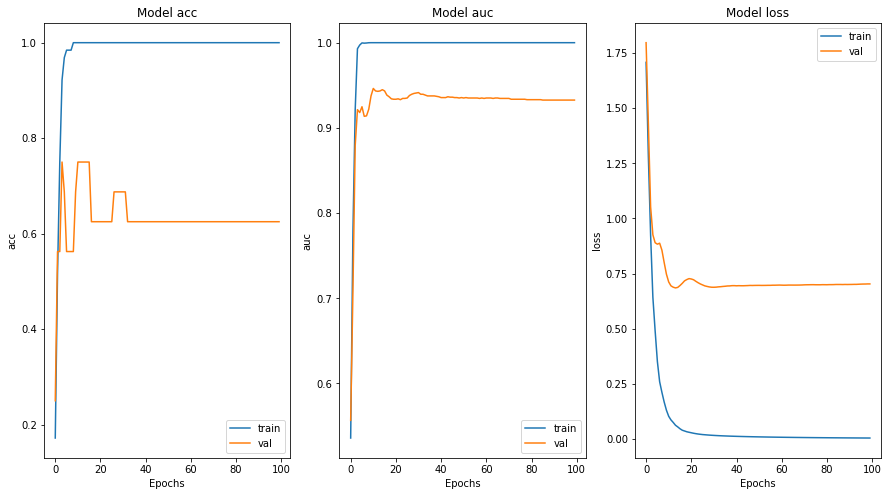

In [11]:
##### Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (15, 8))
ax = ax.ravel()


for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [12]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

1/1 [==============================] - 1s 995ms/step - loss: 0.2065 - acc: 0.9500 - auc: 0.9981 - f1_score: 0.9418
Testing Accuracy: 95.00%


In [13]:
#Predicting the test data

pred_labels = model.predict(test_data)

In [14]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

              precision    recall  f1-score   support

     bokchoy       1.00      1.00      1.00         5
       green       0.83      1.00      0.91         5
        napa       1.00      0.67      0.80         3
         red       1.00      1.00      1.00         4
       savoy       1.00      1.00      1.00         3

   micro avg       0.95      0.95      0.95        20
   macro avg       0.97      0.93      0.94        20
weighted avg       0.96      0.95      0.95        20
 samples avg       0.95      0.95      0.95        20



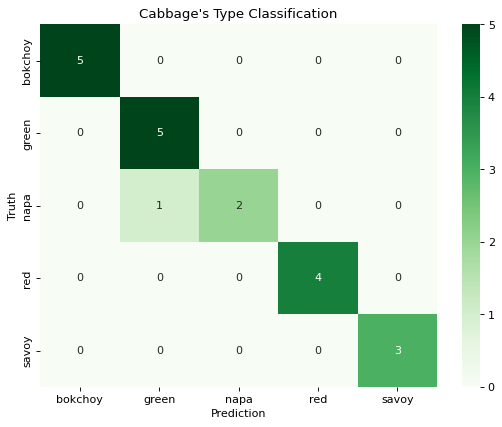

In [15]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Cabbage\'s Type Classification')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [16]:
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 93.33 %
Matthew's Correlation Coefficient: 93.93 %


In [17]:
model.save('model.h5')
#model.save('model.json')

In [18]:
!pip install tf2onnx
import tensorflow as tf
import tf2onnx
import onnx

input_signature = [tf.TensorSpec([None ,150, 150, 3], tf.float32, name='x')]
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=13)
onnx.save(onnx_model, "model.onnx")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.6/440.6 kB 1.2 MB/s eta 0:00:00


2022-07-25 17:26:50.498120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 17:26:50.498501: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-07-25 17:26:50.498636: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-07-25 17:26:50.499210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 17:26:50.499615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 17:26:50.499925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su